<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

**Задача 1**

- Даны значения величины заработной платы заемщиков банка (salary) и значения их поведенческого кредитного скоринга (scoring):

   - salary = [35, 45, 190, 200, 40, 70, 54, 150, 120, 110]
   - scoring = [401, 574, 874, 919, 459, 739, 653, 902, 746, 832]

- Возьмём в качестве признака значение salary, а в качестве целевой переменной - scoring.

- Найдите коэффициенты линейной регрессии с помощью формул для парной регрессии, а затем с помощью метода наименьших квадратов.
- Постройте scatter plot по данным и отметьте на нём прямую линейной регрессии, полученную в п. 1.
- Посчитайте коэффициент детерминации, среднюю ошибку аппроксимации.
- Оцените построенное уравнение регрессии с помощью F-критерия Фишера.
- Постройте для коэффициентов регрессии доверительные интервалы с помощью t-статистики Стьюдента.

In [2]:
salary = np.array([35, 45, 190, 200, 40, 70, 54, 150, 120, 110])
scoring = np.array([401, 574, 874, 919, 459, 739, 653, 902, 746, 832])

In [3]:
# 1.1. РАСЧЕТ МОДЕЛИ
# вариант 1. Расчет параметров модели через коэффициенты корелляции
b1 = ((scoring*salary).mean() - scoring.mean()*salary.mean()) / ((salary*salary).mean() - (salary.mean())**2)
b0 = scoring.mean() - b1*salary.mean()

# вариант 2. Расчет параметров модели через МНК
ones = np.ones((len(salary),1))
salary_vector = np.matrix(salary).T
X = np.hstack((ones, salary_vector))
scoring_vector = np.matrix(scoring).T
XTX = X.T.dot(X)
XTX_inv = np.linalg.inv(XTX)
b_vector = XTX_inv.dot(X.T).dot(scoring_vector)

# Вариант 3. Модуль STATSMODEL (для целей проверки)
data = pd.DataFrame([])
data['salary'] = salary
data['scoring'] = scoring
model = ols(formula="scoring~salary", data=data).fit()

# СВЕРКА
print(f'прямое решение: b0 = {b0}, b1 = {b1}')
print(f'матричное решение: b0 = {b_vector[0]}, b1 = {b_vector[1]}')
print(f'проверка (statsmodels): b0 = {model.params[0]}, b1 = {model.params[1]}')

прямое решение: b0 = 444.1773573243596, b1 = 2.620538882402765
матричное решение: b0 = [[444.17735732]], b1 = [[2.62053888]]
проверка (statsmodels): b0 = 444.1773573243592, b1 = 2.620538882402766


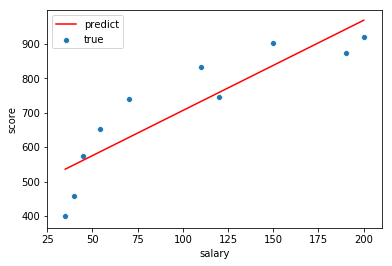

In [4]:
# 1.2. CHART
salary_space = np.linspace(start=salary.min(), stop=salary.max(), num=len(salary))
scoring_predict = b0+b1*salary_space
sns.lineplot(salary_space, scoring_predict, color='r', label='predict')
sns.scatterplot(salary, scoring, label='true')
plt.xlabel('salary')
plt.ylabel('score')
plt.show()

In [5]:
# 1.3. MODEL VALIDATION
scoring_predict = b0+b1*salary
R2 = scoring_predict.var() / scoring.var()
MAE = np.abs((scoring - scoring_predict) / scoring).mean()
print(f'MAE = {MAE}')
print(f'Rsq = {R2}, from statsmodel Rsq = {model.rsquared}')

MAE = 0.11469251843561709
Rsq = 0.7876386635293678, from statsmodel Rsq = 0.7876386635293685


In [6]:
# 1.4. F-STAT
n = len(scoring)
k = 1
alpha = 0.05
F_crit = stats.f.ppf(1-alpha, n-k-1, k)
T = (R2/(1-R2)) * ((n-k-1)/k)
print(f'значение F-stat = {T}, как и в расчетах statsmodel ({model.fvalue}), \nменьше крит.значения {F_crit}, поэтому модель значима')

значение F-stat = 29.67164085966437, как и в расчетах statsmodel (29.671640859664485), 
меньше крит.значения 238.88269480252382, поэтому модель значима


In [7]:
# 1.5. Значимость коэффициентов регрессии
b1_se = np.sqrt( ( (1/(n-2))*sum((scoring-scoring_predict)**2) ) / sum((salary-salary.mean())**2) )
b0_se = b1_se * np.sqrt( sum(salary**2) / n )
t = stats.t.ppf(1 - alpha / 2, df = n - 2)
b1_confint = (b1 - t * b1_se, b1 + t * b1_se)
b0_confint = (b0 - t * b0_se, b0 + t * b0_se)
print(f'доверительный интервал для b1={b1}: {b1_confint}')
print(f'доверительный интервал для b0={b0}: {b0_confint}')
print('оба коэффициента значимы')
print(f'p-values: для b1 - {model.pvalues[1]}, для b0 - {model.pvalues[0]}')

доверительный интервал для b1=2.620538882402765: (1.5111599662593715, 3.7299177985461585)
доверительный интервал для b0=444.1773573243596: (313.9653804816363, 574.3893341670829)
оба коэффициента значимы
p-values: для b1 - 0.0006107546587257499, для b0 - 4.929478857866379e-05


**Задача 2**

Допустим, первые 5 клиентов из предыдущего задания проживают в Москве, а остальные - в Санкт-Петербурге. Влияет ли этот фактор на значение их кредитного скоринга?

In [8]:
# 2.1. Модифицируем данные
location = np.array([1,1,1,1,1,0,0,0,0,0]) # Москва = 1, Питер = 0
# 2.2. Построение прямой модели (для проверки), без дисперсионного анализа
data2 = pd.DataFrame([])
data2['location'] = location
data['scoring'] = scoring
model = ols(formula="scoring~location", data=data2).fit()
display(model.summary2())
# как видно из отчета внизу в целом регрессия незначима (p-value for F > 0.05), 
# также незначим коэффициент location (p-value = 0.29)
# проверим данные выводы через дисперсионный анализ

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.029   
Dependent Variable: scoring          AIC:                134.1553
Date:               2019-11-28 16:15 BIC:                134.7605
No. Observations:   10               Log-Likelihood:     -65.078 
Df Model:           1                F-statistic:        1.265   
Df Residuals:       8                Prob (F-statistic): 0.293   
R-squared:          0.137            Scale:              32886.  
-----------------------------------------------------------------
               Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
-----------------------------------------------------------------
Intercept     774.4000  81.0997  9.5487 0.0000  587.3838 961.4162
location     -129.0000 114.6923 -1.1247 0.2933 -393.4809 135.4809
-----------------------------------------------------------------
Omnibus:              0.579        Durbin-Watson:           1.739
Prob(Omnibus):        0.748        Jarque-Bera (JB):        0.562
Skew:                 0.267        Prob(JB):                0.755
Kurtosis:             1.969        Condition No.:           3    
=================================================================

"""

In [9]:
# 2.3. Дисперсионный анализ
#loc1, loc2 = location[:5], location[5:]
scoring1, scoring2 = scoring[:5], scoring[5:]
n, n1, n2 = len(scoring), len(scoring1), len(scoring2)
#display(scoring1.mean(), scoring2.mean(), scoring.mean())
S2 = sum((scoring - scoring.mean())**2)
S2_F = n1*(scoring1.mean() - scoring.mean())**2 + n2*(scoring2.mean() - scoring.mean())**2 
S2_res = sum( (scoring1 - scoring1.mean())**2 ) + sum( (scoring2 - scoring2.mean())**2 )
print(f'общая дисперсия = {S2}, S2_F + S2_res = {S2_F+S2_res}')

k = 2
sigma2_F = S2_F / (k-1)
sigma2_res = S2_res / (n-k)
T = sigma2_F / sigma2_res

alpha = 0.05
F_crit = stats.f.ppf(1 - alpha, k-1, n-k)
print(f'T = {T} < Fcrit={F_crit}, поэтому параметр города статистически не значим')

общая дисперсия = 304688.9000000001, S2_F + S2_res = 304688.89999999997
T = 1.2650596914169643 < Fcrit=5.317655071578714, поэтому параметр города статистически не значим


**Задача 3**

Посчитать коэффициенты линейной регрессии для т.н. Квартета Энскомба (см. урок 6).

In [10]:
df = pd.read_csv('anscombe_dataset.csv', index_col='id')
pairs = (('x1', 'y1'),('x2', 'y2'),('x3', 'y3'),('x4', 'y4'))
for pair in pairs:
    print(pair)
    print(50*'=')
    X = pd.DataFrame(df[pair[0]])
    y = pd.DataFrame(df[pair[1]])
    model = LinearRegression()
    model.fit(X, y)
    y_predict = model.predict(X)
    print(f'b1 = {model.coef_}, b0 = {model.intercept_}')
    print(f'R2 = {r2_score(y, y_predict)}')
    print(50*'_')

('x1', 'y1')
b1 = [[0.50009091]], b0 = [3.00009091]
R2 = 0.666542459508775
__________________________________________________
('x2', 'y2')
b1 = [[0.5]], b0 = [3.00090909]
R2 = 0.6662420337274844
__________________________________________________
('x3', 'y3')
b1 = [[0.49972727]], b0 = [3.00245455]
R2 = 0.6663240410665592
__________________________________________________
('x4', 'y4')
b1 = [[0.49990909]], b0 = [3.00172727]
R2 = 0.6667072568984653
__________________________________________________
